In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv(r'C:\Users\dearm\OneDrive\Documents\PYTORCH_NOTEBOOKS\Data\TimeSeriesData\Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.tail()

325


,IPG2211A2N
DATE,
2018-09-01,101.5656
2018-10-01,95.3203
2018-11-01,103.5750
2018-12-01,112.9498
2019-01-01,123.7687


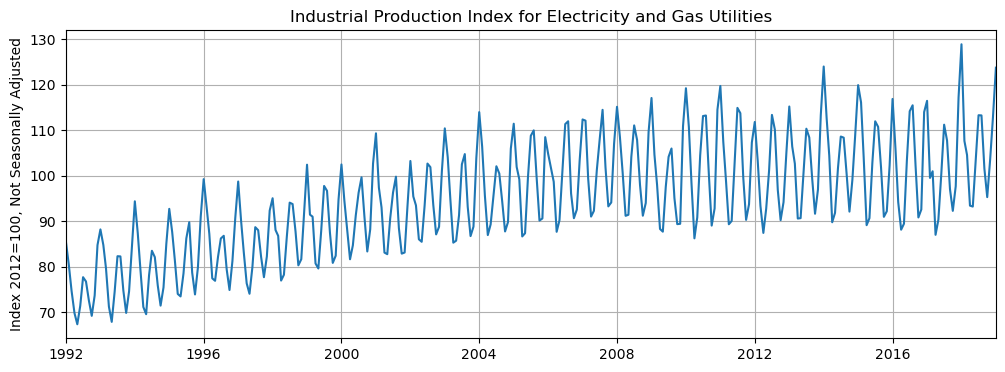

In [2]:
# view data
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

In [3]:
# divide data into test and train sets
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

In [4]:
# normalize the training set
scaler = MinMaxScaler(feature_range=(-1, 1))


train_norm = scaler.fit_transform(train_set.reshape(-1,1))

In [5]:
# prepare list of windowed sequence/label tuples
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [6]:
train_data = input_data(train_norm, window_size)

In [7]:
# define the model
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
    
        self.lstm = nn.LSTM(input_size, hidden_size)

        self.linear = nn.Linear(hidden_size, output_size)

        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))
    
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [8]:
# set random seed and instantiate model
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [9]:
# define loss and optimization functions
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# train the model!
epochs = 50

for epoch in range(epochs):
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch+1}   Loss: {loss.item():10.8f}')

Epoch: 1   Loss: 0.73148292
Epoch: 2   Loss: 0.32224435
Epoch: 3   Loss: 0.24065642
Epoch: 4   Loss: 0.22756004
Epoch: 5   Loss: 0.21153599
Epoch: 6   Loss: 0.19906579
Epoch: 7   Loss: 0.19067460
Epoch: 8   Loss: 0.18480708
Epoch: 9   Loss: 0.17962381
Epoch: 10   Loss: 0.17441957
Epoch: 11   Loss: 0.16898848
Epoch: 12   Loss: 0.16325678
Epoch: 13   Loss: 0.15732820
Epoch: 14   Loss: 0.15139399
Epoch: 15   Loss: 0.14566247
Epoch: 16   Loss: 0.14030805
Epoch: 17   Loss: 0.13544109
Epoch: 18   Loss: 0.13110325
Epoch: 19   Loss: 0.12727925
Epoch: 20   Loss: 0.12391789
Epoch: 21   Loss: 0.12095382
Epoch: 22   Loss: 0.11832570
Epoch: 23   Loss: 0.11598344
Epoch: 24   Loss: 0.11389026
Epoch: 25   Loss: 0.11202085
Epoch: 26   Loss: 0.11036167
Epoch: 27   Loss: 0.10891443
Epoch: 28   Loss: 0.10769790
Epoch: 29   Loss: 0.10674413
Epoch: 30   Loss: 0.10608401
Epoch: 31   Loss: 0.10575970
Epoch: 32   Loss: 0.10588426
Epoch: 33   Loss: 0.10653224
Epoch: 34   Loss: 0.10749183
Epoch: 35   Loss: 0.108

In [11]:
# evaluate the test set
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [12]:
# inverse transform the predicted values to original test set range
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [13]:
# plot the results
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

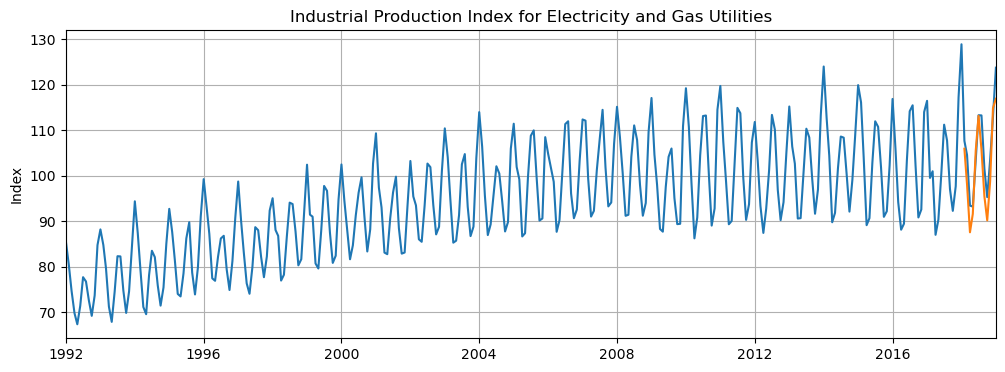

In [14]:
# display predictions in orange and true values in blue
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()